In [1]:
#-----------------------------------
# TRAINING OUR MODEL
#-----------------------------------
import h5py
import numpy as np
import os
import glob
import cv2
import warnings
from matplotlib import pyplot
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import joblib
import mahotas
from sklearn.preprocessing import MinMaxScaler
warnings.filterwarnings('ignore')

#--------------------
# tunable-parameters
#--------------------
num_trees = 100
test_size = 0.25
seed      = 9
fixed_size       = tuple((768, 768))
train_path = "dataset/train"
test_path  = "dataset/test"
h5_data    = 'output/data.h5'
h5_labels  = 'output/labels.h5'
scoring    = "accuracy"
bins             = 5
#num_classes = 5

# get the training labels
train_labels = os.listdir(train_path)

# sort the training labels
train_labels.sort()

if not os.path.exists(test_path):
    os.makedirs(test_path)

# create all the machine learning models
models = []
models.append(('LR', LogisticRegression(random_state=seed)))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier(random_state=seed)))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(random_state=seed)))

# variables to hold the results and names
results = []
names   = []

# import the feature vector and trained labels
h5f_data  = h5py.File(h5_data, 'r')
h5f_label = h5py.File(h5_labels, 'r')

global_features_string = h5f_data['dataset_1']
global_labels_string   = h5f_label['dataset_1']

global_features = np.array(global_features_string)
global_labels   = np.array(global_labels_string)

h5f_data.close()
h5f_label.close()

# verify the shape of the feature vector and labels
print("[STATUS] features shape: {}".format(global_features.shape))
print("[STATUS] labels shape: {}".format(global_labels.shape))

print("[STATUS] training started...")

[STATUS] features shape: (15000, 145)
[STATUS] labels shape: (15000,)
[STATUS] training started...


In [2]:
# split the training and testing data
(trainDataGlobal, testDataGlobal, trainLabelsGlobal, testLabelsGlobal) = train_test_split(np.array(global_features),
                                                                                          np.array(global_labels),
                                                                                          test_size=test_size,
                                                                                          random_state=seed)

print("[STATUS] splitted train and test data...")
print("Train data  : {}".format(trainDataGlobal.shape))
print("Test data   : {}".format(testDataGlobal.shape))
print("Train labels: {}".format(trainLabelsGlobal.shape))
print("Test labels : {}".format(testLabelsGlobal.shape))

[STATUS] splitted train and test data...
Train data  : (11250, 145)
Test data   : (3750, 145)
Train labels: (11250,)
Test labels : (3750,)


LR: 0.927733 (0.007134)
LDA: 0.933600 (0.005364)
KNN: 0.987200 (0.002673)
CART: 0.983467 (0.002953)
RF: 0.994044 (0.001641)
NB: 0.704178 (0.010636)
SVM: 0.931022 (0.007001)


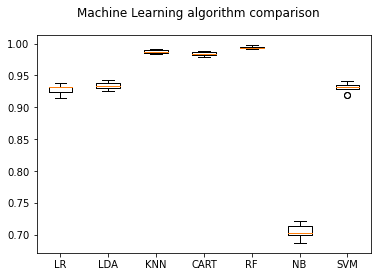

In [3]:
# 10-fold cross validation
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, trainDataGlobal, trainLabelsGlobal, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# boxplot algorithm comparison
fig = pyplot.figure()
fig.suptitle('Machine Learning algorithm comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

In [4]:
#-----------------------------------
# TESTING OUR MODEL
#-----------------------------------

# to visualize results
import matplotlib.pyplot as plt
import pandas as pd

import sklearn.linear_model as sk

# instantiate model
clf = LogisticRegression()


# create the model - Random Forests
#clf  = RandomForestClassifier(n_estimators=num_trees, random_state=seed)

# fit the training data to the model
clf.fit(trainDataGlobal, trainLabelsGlobal)


print ("Accuracy on testing set:")
print (clf.score(testDataGlobal, testLabelsGlobal))

#predictions = clf.predict(rescaledY)
predictions = clf.predict(testDataGlobal)
print ("Display Summary:")
#display_summary(testDataGlobal,predictions)

cm1 = confusion_matrix(testLabelsGlobal, predictions)

print(cm1)
print(classification_report(testLabelsGlobal,predictions))


Accuracy on testing set:
0.9293333333333333
Display Summary:
[[1080   20   95]
 [  33 1232    0]
 [ 117    0 1173]]
              precision    recall  f1-score   support

           0       0.88      0.90      0.89      1195
           1       0.98      0.97      0.98      1265
           2       0.93      0.91      0.92      1290

    accuracy                           0.93      3750
   macro avg       0.93      0.93      0.93      3750
weighted avg       0.93      0.93      0.93      3750



In [5]:
# IMPORTANT: first argument is true values, second argument is predicted values
# this produces a 2x2 numpy array (matrix)
from sklearn import metrics
print(metrics.confusion_matrix(testLabelsGlobal,predictions))

[[1080   20   95]
 [  33 1232    0]
 [ 117    0 1173]]


In [6]:
# save confusion matrix and slice into four pieces
confusion = metrics.confusion_matrix(testLabelsGlobal,predictions)
print(confusion)
#[row, column]
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

[[1080   20   95]
 [  33 1232    0]
 [ 117    0 1173]]


In [7]:
# use float to perform true division, not integer division
print((TP + TN) / float(TP + TN + FP + FN))
print(metrics.accuracy_score(testLabelsGlobal,predictions))

0.9775898520084566
0.9293333333333333


In [8]:
sensitivity = TP / float(FN + TP)

print(sensitivity)
print(metrics.recall_score(testLabelsGlobal,predictions, average='weighted'))

0.9739130434782609
0.9293333333333333


In [9]:
specificity = TN / (TN + FP)

print(specificity)

0.9818181818181818


In [10]:
false_positive_rate = FP / float(TN + FP)

print(false_positive_rate)
print(1 - specificity)

0.01818181818181818
0.018181818181818188


In [11]:
precision = TP / float(TP + FP)

print(precision)
print(metrics.precision_score(testLabelsGlobal,predictions, average='weighted'))

0.9840255591054313
0.929976629324552


In [12]:
# print the first 10 predicted responses
# 1D array (vector) of binary values (0, 1)
clf.predict(testDataGlobal)[0:10]

array([1, 1, 2, 0, 2, 1, 0, 1, 2, 2], dtype=int64)

In [13]:
# print the first 10 predicted probabilities of class membership
clf.predict_proba(testDataGlobal)[0:10]

array([[2.78204911e-04, 9.99399719e-01, 3.22075643e-04],
       [2.57230796e-05, 9.99973003e-01, 1.27436598e-06],
       [1.28853776e-01, 5.28103406e-05, 8.71093414e-01],
       [9.08102707e-01, 1.04568500e-02, 8.14404426e-02],
       [7.16457322e-03, 2.19808318e-04, 9.92615618e-01],
       [2.14136393e-05, 9.99977378e-01, 1.20875733e-06],
       [9.30233653e-01, 2.29830437e-03, 6.74680426e-02],
       [5.65962564e-05, 9.99674840e-01, 2.68563674e-04],
       [5.51795581e-02, 2.89451449e-02, 9.15875297e-01],
       [1.35736971e-01, 3.28761931e-04, 8.63934267e-01]])

In [14]:
# print the first 10 predicted probabilities for class 1
clf.predict_proba(testDataGlobal)[0:10, 1]

array([9.99399719e-01, 9.99973003e-01, 5.28103406e-05, 1.04568500e-02,
       2.19808318e-04, 9.99977378e-01, 2.29830437e-03, 9.99674840e-01,
       2.89451449e-02, 3.28761931e-04])

In [15]:
# store the predicted probabilities for class 1
y_pred_prob = clf.predict_proba(testDataGlobal)[:, 1]

In [16]:
y_pred_prob

array([9.99399719e-01, 9.99973003e-01, 5.28103406e-05, ...,
       9.98902802e-01, 2.40616345e-03, 1.67769772e-05])

In [17]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

Text(0, 0.5, 'Frequency')

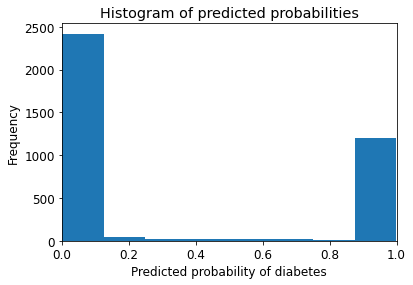

In [18]:
# histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of diabetes')
plt.ylabel('Frequency')

In [19]:
# predict lung cancer if the predicted probability is greater than 0.3
from sklearn.preprocessing import binarize
# it will return 1 for all values above 0.3 and 0 otherwise
# results are 2D so we slice out the first column
predictions = binarize([y_pred_prob], 0.3)[0]


In [20]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([9.99399719e-01, 9.99973003e-01, 5.28103406e-05, 1.04568500e-02,
       2.19808318e-04, 9.99977378e-01, 2.29830437e-03, 9.99674840e-01,
       2.89451449e-02, 3.28761931e-04])

In [21]:
# print the first 10 predicted classes with the lower threshold
predictions[0:10]

array([1., 1., 0., 0., 0., 1., 0., 1., 0., 0.])

In [22]:
# previous confusion matrix (default threshold of 0.5)
print(confusion)

[[1080   20   95]
 [  33 1232    0]
 [ 117    0 1173]]


In [23]:
# new confusion matrix (threshold of 0.3)
rev_confusion = metrics.confusion_matrix(testLabelsGlobal,predictions)
print(rev_confusion)

[[1171   24    0]
 [  14 1251    0]
 [1289    1    0]]


In [24]:
# sensitivity has increased 
rTP = rev_confusion[1, 1]
rTN = rev_confusion[0, 0]
rFP = rev_confusion[0, 1]
rFN = rev_confusion[1, 0]

rsensitivity = rTP / float(rFN + rTP)
print(rsensitivity)

0.9889328063241106


In [25]:
# specificity has decreased 
specificity = rTN / (rTN + rFP)
print(specificity)

0.9799163179916318


In [35]:
# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob
# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(testLabelsGlobal,predictions)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for Random Forest Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

ValueError: multiclass format is not supported

In [39]:
#Compute AUC for multiclass
#https://medium.com/@plog397/auc-roc-curve-scoring-function-for-multi-class-classification-9822871a6659
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

def multiclass_roc_auc_score(y_test, y_pred, average="macro"):
    lb = LabelBinarizer()
    lb.fit(y_test)
    y_test = lb.transform(y_test)
    y_pred = lb.transform(y_pred)
    return roc_auc_score(y_test, y_pred, average=average)

aucScore = multiclass_roc_auc_score(testLabelsGlobal,predictions)
print(aucScore)

0.7414680552690548
